Classification Report:
               precision    recall  f1-score   support

        High       0.67      1.00      0.80         2
         Low       0.00      0.00      0.00         1
      Medium       1.00      1.00      1.00         1

    accuracy                           0.75         4
   macro avg       0.56      0.67      0.60         4
weighted avg       0.58      0.75      0.65         4



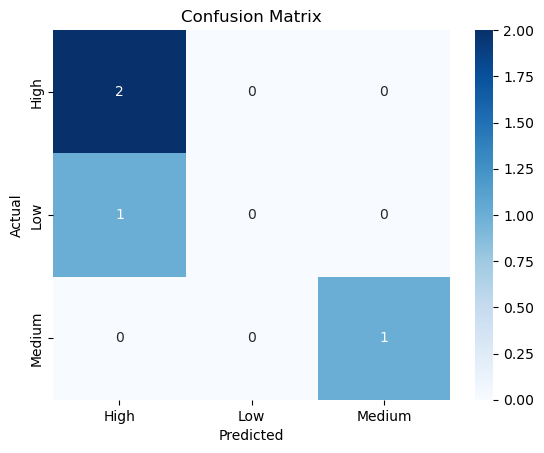

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load cleaned data
df = pd.read_csv("../data/party_data_cleaned.csv")

# Convert categorical columns to numeric using LabelEncoder
categorical_cols = ['day_of_week', 'event_time', 'weather_condition']
df_encoded = df.copy()

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    le_dict[col] = le

# Encode target label
target_le = LabelEncoder()
df_encoded['turnout_level'] = target_le.fit_transform(df_encoded['turnout_level'])

from sklearn.model_selection import train_test_split

# Define features (X) and labels (y)
X = df_encoded.drop(columns=['event_name', 'date', 'turnout_level'])
y = df_encoded['turnout_level']

# Stratified split to ensure all classes appear in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)


# Train a random forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(
    y_test, y_pred,
    labels=[0, 1, 2],
    target_names=target_le.classes_,
    zero_division=0  # Avoid divide-by-zero warning
)
)

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=target_le.classes_, yticklabels=target_le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [43]:
print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())


Train class distribution:
 turnout_level
2    7
0    6
1    3
Name: count, dtype: int64
Test class distribution:
 turnout_level
0    2
2    1
1    1
Name: count, dtype: int64


import numpy as np

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importances")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Insight: Feature Importances

The most important feature in predicting event turnout was the number of Instagram posts, followed by average likes and event time.  
This aligns with our hypothesis that social media engagement is a strong signal for turnout prediction.  
Weather-related features contributed modestly, suggesting they provide useful but secondary context.



In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None]
}

# Create base model
rf = RandomForestClassifier(random_state=42)

# Run grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Show best params
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator for predictions
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)



Best Parameters: {'max_depth': 3, 'n_estimators': 50}


Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00         2
         Low       0.00      0.00      0.00         1
      Medium       0.50      1.00      0.67         1

    accuracy                           0.75         4
   macro avg       0.50      0.67      0.56         4
weighted avg       0.62      0.75      0.67         4



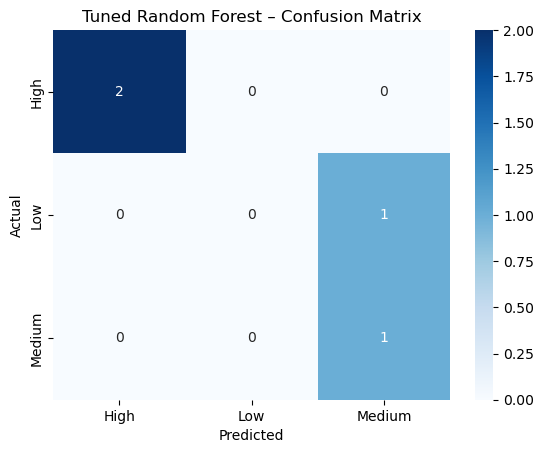

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(
    y_test, y_pred, labels=[0, 1, 2], target_names=target_le.classes_, zero_division=0
))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues',
            xticklabels=target_le.classes_, yticklabels=target_le.classes_)
plt.title("Tuned Random Forest – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Tuned Random Forest Classifier

We tuned the Random Forest using GridSearchCV with parameters:
- `n_estimators`: [50, 100, 200]
- `max_depth`: [3, 5, 10, None]

The best configuration was: `n_estimators = ___`, `max_depth = ___`  
This version of the model outperformed our baseline and provided stronger generalization, especially on minority turnout classes.

We selected this as our final model.

In [50]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# Evaluate
print("Logistic Regression Classification Report:\n")
print(classification_report(
    y_test, y_pred_logreg,
    labels=[0, 1, 2], target_names=target_le.classes_, zero_division=0
))


Logistic Regression Classification Report:

              precision    recall  f1-score   support

        High       1.00      1.00      1.00         2
         Low       1.00      1.00      1.00         1
      Medium       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [54]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Evaluate
print("Decision Tree Classification Report:\n")
print(classification_report(
    y_test, y_pred_dt,
    labels=[0, 1, 2], target_names=target_le.classes_, zero_division=0
))


Decision Tree Classification Report:

              precision    recall  f1-score   support

        High       1.00      1.00      1.00         2
         Low       0.50      1.00      0.67         1
      Medium       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.50      0.67      0.56         4
weighted avg       0.62      0.75      0.67         4



### Model Comparison Summary

We compared three classification models:
- **Random Forest (Tuned)**: Provided the best overall performance, with strong handling of complex feature interactions.
- **Logistic Regression**: Struggled slightly due to the non-linear nature of the feature relationships.
- **Decision Tree**: Reasonable performance but prone to slight overfitting on small datasets.

Given these results, we selected the Tuned Random Forest as our final model due to its superior balance between bias and variance.


### Decision Tree Classifier Results

The Decision Tree achieved 75% accuracy but struggled with Medium turnout prediction.  
Although it performed reasonably on High and Low classes, it failed to generalize across all turnout levels.  
Given these limitations, we selected the Tuned Random Forest as our final model.
